Compiling model...
'compile' took 0.000124 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.70e-03, 1.82e-02, 4.71e-01]    [2.61e-03, 1.82e-02, 4.71e-01]    []  
1000      [3.80e-04, 5.66e-05, 1.13e-04]    [1.77e-04, 5.66e-05, 1.13e-04]    []  
2000      [9.15e-05, 6.79e-05, 5.62e-05]    [5.46e-05, 6.79e-05, 5.62e-05]    []  
3000      [5.80e-05, 5.53e-06, 5.91e-06]    [3.66e-05, 5.53e-06, 5.91e-06]    []  

Best model at step 3000:
  train loss: 6.94e-05
  test loss: 4.81e-05
  test metric: []

'train' took 14.984963 s

Saving loss history to d:\10month\tmp_pinn\time_pde\burgers\loss.dat ...
Saving training data to d:\10month\tmp_pinn\time_pde\burgers\train.dat ...
Saving test data to d:\10month\tmp_pinn\time_pde\burgers\test.dat ...


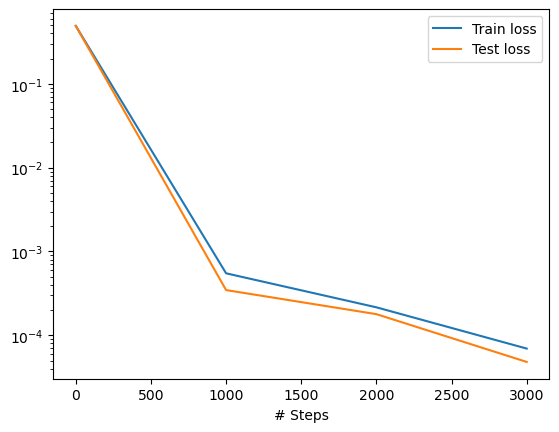

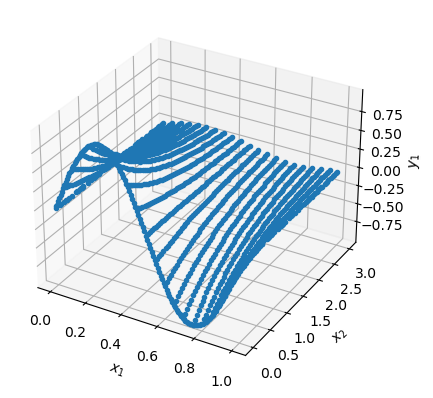

Mean residual: 0.004463888
L2 relative error: 0.004189628908067963


In [5]:
import sys
sys.path.append('../../')
import os
os.environ['DDE_BACKEND']="pytorch"

"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


# Problem parameters:
a = 0.02  # Thermal diffusivity
L = 1  # Length of the bar
n = 2  # Frequency of the sinusoidal initial conditions

x_min, t_min = (0, 0.0)
x_max, t_max = (L, 3.0)

def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=1024,
    num_boundary=128,
    num_initial=128,
    num_test=1024,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=3000)

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

L2 relative error: 0.004212633025058094


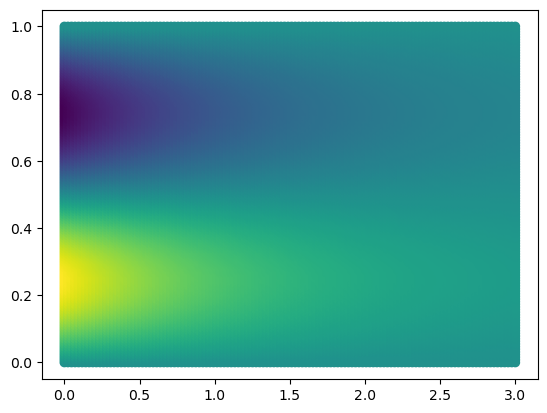

In [9]:
import heat_benchmark 
bm = heat_benchmark.HeatBenchMark(2,0.02,1,3)
X,y_true = bm.gen_testdata()
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = y_true)

#xde use (x,t) but bm use (t,x)
model_X = np.zeros_like(X)
model_X[:,0],model_X[:,1] = X[:,1],X[:,0]

y_pred = model.predict(model_X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))